# Data

In [12]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
style.use('ggplot')

In [13]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2016, 12, 31)

df = web.DataReader('AAPL', 'yahoo', start, end)
print(df.head())
df.to_csv('./1.data/AAPL.csv')

                  Open        High         Low       Close     Volume  \
Date                                                                    
2000-01-03  104.874997  112.499998  101.687501  111.937502  133949200   
2000-01-04  108.250001  110.625002  101.187503  102.500003  128094400   
2000-01-05  103.749998  110.562497  103.000001  103.999997  194580400   
2000-01-06  106.124999  106.999999   94.999998   94.999998  191993200   
2000-01-07   96.499999  101.000002   95.500003   99.500001  115183600   

            Adj Close  
Date                   
2000-01-03   3.625643  
2000-01-04   3.319964  
2000-01-05   3.368548  
2000-01-06   3.077039  
2000-01-07   3.222794  


In [14]:
df = pd.read_csv('./1.data/AAPL.csv', parse_dates = True, index_col = 0) #index by first column, instead of 0, 1, 2..

In [15]:
df['100ma'] = df['Adj Close'].rolling(window = 100, min_periods = 0).mean() # create new column of 100ma
print(df.head())

                  Open        High         Low       Close     Volume  \
Date                                                                    
2000-01-03  104.874997  112.499998  101.687501  111.937502  133949200   
2000-01-04  108.250001  110.625002  101.187503  102.500003  128094400   
2000-01-05  103.749998  110.562497  103.000001  103.999997  194580400   
2000-01-06  106.124999  106.999999   94.999998   94.999998  191993200   
2000-01-07   96.499999  101.000002   95.500003   99.500001  115183600   

            Adj Close     100ma  
Date                             
2000-01-03   3.625643  3.625643  
2000-01-04   3.319964  3.472804  
2000-01-05   3.368548  3.438052  
2000-01-06   3.077039  3.347799  
2000-01-07   3.222794  3.322798  


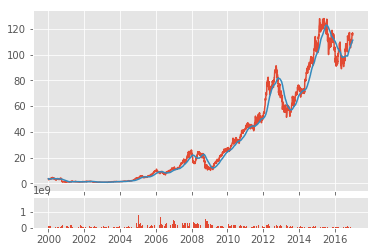

In [16]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1) #size of grid, starting position, width of graph, height of graph
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 1, colspan = 1, sharex = ax1)

ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100ma'])
ax2.bar(df.index, df['Volume'])

plt.show()

# Database

In [42]:
import sqlite3
import os

conn = sqlite3.connect('./3.db/finance.db')
c = conn.cursor()

c.execute("SELECT * FROM users")
results = c.fetchall()

conn.close()

In [43]:
print(results)

[(4, 'george', '$pbkdf2-sha256$29000$uDcmpLRWqnWOMUZoDeEc4w$nZHbBhVsOSMeuuVx.EjWJwAQD3zz.W/zO/trExfYIKk', 1.939999999999955), (5, 'Bla', '$pbkdf2-sha256$29000$3HtvLSUEQIixdk7JOScE4A$Snw//x6VYqlmjd0MAurZjf/5o/C.D4pgWJ7rGesMjuc', 10000), (6, 'chuck', '$pbkdf2-sha256$29000$spbSOmcMoXTuHYOQcu6dEw$NaCRPmP/FsVG4XZTYGQV7Kr9ZgacSuEPY4g7xG1.2R8', 9995.16)]


# Modeling

In [66]:
def lookup(symbol):
    """Look up quote for symbol."""

    # reject symbol if it starts with caret
    if symbol.startswith("^"):
        return None

    # reject symbol if it contains comma
    if "," in symbol:
        return None

    # query Yahoo for quote
    # http://stackoverflow.com/a/21351911
    try:
        url = "http://download.finance.yahoo.com/d/quotes.csv?f=snl1&s={}".format(symbol)
        webpage = urllib.request.urlopen(url)
        datareader = csv.reader(webpage.read().decode("utf-8").splitlines())
        row = next(datareader)
    except:
        return None

    # ensure stock exists
    try:
        price = float(row[2])
    except:
        return None

    # return stock's name (as a str), price (as a float), and (uppercased) symbol (as a str)
    return {
        "name": row[1],
        "price": price,
        "ticker": row[0].upper()
    }

print(lookup("AAPL"))

{'name': 'Apple Inc.', 'price': 141.83, 'ticker': 'AAPL'}


In [40]:
def quote(ticker):
    return lookup(ticker).get("price")

print(quote("AAPL"))

In [54]:
from cs50 import SQL
db = SQL("sqlite:///3.db/finance.db")
session = {'user_id':4}

In [73]:
def sell(ticker, shares):
    # Check for shares in portfolio
    portfolio = db.execute("SELECT symbol, SUM(shares) AS shares FROM history WHERE user_id = :id GROUP BY 1 HAVING symbol = :symbol", 
        id=session["user_id"], symbol = ticker.upper())
    if len(portfolio) < 1:
        return None
    if float(shares) > portfolio[0].get("shares"):
        return None
    # Current stock price
    price = lookup(ticker).get("price")
    # Amount in bank account
    cash = db.execute("SELECT * FROM users WHERE id = :id", id=session["user_id"])[0].get("cash")
    # Store who, what, how many, how much, when
    db.execute("INSERT INTO history (user_id, symbol, shares, price) VALUES(:user_id, :symbol, :shares, :price)", 
                user_id = session["user_id"], symbol = ticker.upper(), 
                shares = -1 * float(shares), price = price)
    # Add cash to account
    db.execute("UPDATE 'users' SET cash = :cash where id = :id", 
            cash = float(cash) + float(price) * float(shares), id = session["user_id"])
    return "Sold {} shares of {}, at price {}. Remaining balance is {}".format(shares, ticker, price, cash)
    
sell("SNAP", 10)

'Sold 10 shares of SNAP, at price 19.94. Remaining balance is 498.18999999999994'

In [75]:
def buy(ticker, shares):
    # Current stock price
    price = lookup(ticker).get("price")
    # Amount in bank account
    cash = db.execute("SELECT * FROM users WHERE id = :id", id=session["user_id"])[0].get("cash")
    # Check affordability
    if float(price) * float(shares) > float(cash):
        return "you are trying to buy {} shares of {}, which costs {}, but you only have {}".format(shares, ticker, price, cash)
    # Store who, what, how many, how much, when
    db.execute("INSERT INTO history (user_id, symbol, shares, price) VALUES(:user_id, :ticker, :shares, :price)", 
                user_id = session["user_id"], ticker = ticker.upper(), 
                shares = shares, price = price)
    # Reduce cash
    db.execute("UPDATE 'users' SET cash = :cash where id = :id", 
            cash = float(cash) - float(price) * float(shares), id = session["user_id"])
    return "Bought {} shares of {}, at price {}. Remaining balance is {}".format(shares, ticker, price, cash)

buy("AAPL", 1)

'Bought 1 shares of AAPL, at price 141.83. Remaining balance is 697.5899999999999'

In [112]:
def execute(strategy):
    if strategy.get("position") == "buy":
        buy(strategy.get("ticker"), strategy.get("shares"))
    if strategy.get("position") == "sell":
        sell(strategy.get("ticker"), strategy.get("shares"))

In [113]:
def strategy1(df):
    if df['Adj Close'][len(df)-1] > df['100ma'][len(df)-1]:
        position = "buy"
    if df['Adj Close'][len(df)-1] < df['100ma'][len(df)-1]:
        position = "sell"

    # ignore order type for now
    return {
        "ticker": "AAPL",
        "position": position,
        "shares": 1
    }

In [114]:
strategy1(df)

{'position': 'buy', 'shares': 1, 'ticker': 'AAPL'}

In [115]:
execute(strategy1(df))

# Web-application
Control using app.py  
HTML using templates